## Transfer Learning InceptionV3 using Keras

Please download the dataset from the below url

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [1]:
# import the libraries 

from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, Activation, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, load_model, Sequential 
from tensorflow.keras.preprocessing import image
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import numpy as np
import itertools
import keras

In [3]:
# re-size all the images to this
num_classes = 4
input_shape = (256, 256, 3)

train_path = '../data/train'
val_path = '../data/val'

I have modified the AlexNet Architecture as of the following diagram.

<img src="https://github.com/bkget/Leaf-Disease-Classification/blob/main/screenshots/AlexNet%20Architecture.jpg?raw=true" alt="Alternative text"/>

In [ ]:
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape =  (3, 256, 256)
    chanDim = 1

alexnet_model = Sequential()
alexnet_model.add(Conv2D(filters=64, input_shape=input_shape, kernel_size=(3, 3), strides=(2,2), padding='valid'))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#2nd
alexnet_model.add(Conv2D(filters=96, kernel_size=(5, 5), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.01)))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))

#3rd
alexnet_model.add(Conv2D(filters=128, kernel_size=(2,2), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))


#4th
alexnet_model.add(Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))

#5th
alexnet_model.add(Conv2D(filters=64, kernel_size=(1,1), strides=(1,1), padding='valid', activity_regularizer=tf.keras.regularizers.l2(0.1)))
alexnet_model.add(Activation('relu'))
alexnet_model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='valid'))
alexnet_model.add(Dropout(0.4))

# Flattening
alexnet_model.add(Flatten())

# FC layer
alexnet_model.add(Dense(2048))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.5))

#2nd FC layer
alexnet_model.add(Dense(2048))
alexnet_model.add(Activation('relu'))
alexnet_model.add(Dropout(0.4))

#Output layer
alexnet_model.add(Dense(4))
alexnet_model.add(Activation('softmax'))

alexnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 127, 127, 64)      1792      
_________________________________________________________________
activation_9 (Activation)    (None, 127, 127, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 59, 59, 96)        153696    
_________________________________________________________________
activation_10 (Activation)   (None, 59, 59, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 29, 29, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)      

In [ ]:
# Optimization technique 

opt = Adam(lr=0.0001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,  amsgrad=False)

In [ ]:
# tell the model what cost and optimization method to use
alexnet_model.compile(
  loss='categorical_crossentropy',
  optimizer = opt,
  metrics=['accuracy']
)

In [4]:
# Use the Image Data Generator to import the images from the dataset

train_datagen = ImageDataGenerator(rescale = 1./255,
                            #  preprocessing_function = tf.keras.applications.inception_resnet_v2.preprocess_input,
                             rotation_range=10,
                             zoom_range = 0.1,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             shear_range = 0.2, 
                             vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (256, 256),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 6024 images belonging to 4 classes.


In [5]:
test_set = test_datagen.flow_from_directory(val_path,
                                            target_size = (256, 256),
                                            batch_size = 32,
                                            shuffle = False,
                                            class_mode = 'categorical')

Found 1506 images belonging to 4 classes.


In [ ]:
# ReduceLROnPlateau - automatically set the LR if no change is detected
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', 
                                             patience = 3, 
                                             verbose = 1, 
                                             factor = 0.5, 
                                             min_lr = 0.00001)

In [ ]:
# fit the model
# Run the cell. It will take some time to execute
model_history = alexnet_model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  callbacks = [learning_rate_reduction],
  steps_per_epoch = len(training_set),
  validation_steps = len(test_set)  
)

Epoch 1/50
189/189 [==============================] - 5643s 30s/step - loss: 15.4076 - accuracy: 0.2784 - val_loss: 2.9953 - val_accuracy: 0.4495
Epoch 2/50
189/189 [==============================] - 83s 441ms/step - loss: 2.1314 - accuracy: 0.4620 - val_loss: 2.0263 - val_accuracy: 0.6076
Epoch 3/50
189/189 [==============================] - 83s 440ms/step - loss: 1.6717 - accuracy: 0.5698 - val_loss: 1.8620 - val_accuracy: 0.6308
Epoch 4/50
189/189 [==============================] - 83s 438ms/step - loss: 1.4480 - accuracy: 0.6174 - val_loss: 1.7133 - val_accuracy: 0.6527
Epoch 5/50
189/189 [==============================] - 83s 439ms/step - loss: 1.3592 - accuracy: 0.6424 - val_loss: 1.6674 - val_accuracy: 0.6441
Epoch 6/50
189/189 [==============================] - 83s 439ms/step - loss: 1.2933 - accuracy: 0.6518 - val_loss: 1.4919 - val_accuracy: 0.6806
Epoch 7/50
189/189 [==============================] - 83s 437ms/step - loss: 1.1506 - accuracy: 0.6925 - val_loss: 1.4796 - val_a

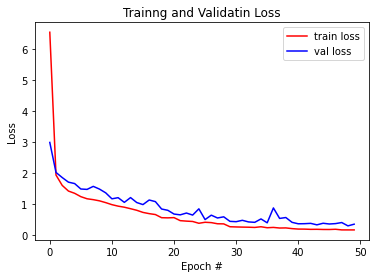

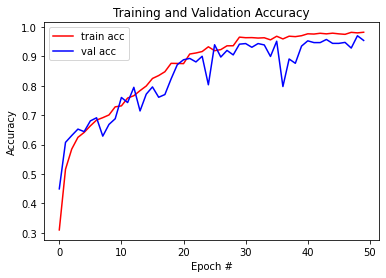

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the loss
plt.plot(model_history.history['loss'],'r', label='train loss')
plt.plot(model_history.history['val_loss'],'b', label='val loss')
plt.title("Trainng and Validatin Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(model_history.history['accuracy'],'r', label='train acc')
plt.plot(model_history.history['val_accuracy'],'b', label='val acc')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
#loss, accuracy = alexnet_model.evaluate(x_test, y_test, verbose=1)
loss, accuracy = alexnet_model.evaluate(test_set, verbose=1)
# loss_v, accuracy_v = alexnet_model.evaluate(x_validate, y_validate, verbose=1)
t_loss, t_accuracy = alexnet_model.evaluate(training_set, verbose=1)

In [ ]:
print("Training: accuracy = %f  ;  loss_v = %f" % (t_accuracy, t_loss))
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Training: accuracy = 0.985226  ;  loss_v = 0.158497
Validation: accuracy = 0.954183  ;  loss = 0.356474


In [ ]:
# save it as a h5 file

alexnet_model = keras.models.load_model('../models/faba_bean_model_modified_AlexNet.h5')

In [6]:
# open saved model file

alexnet_model = keras.models.load_model('../models/faba_bean_model_modified_AlexNet.h5')

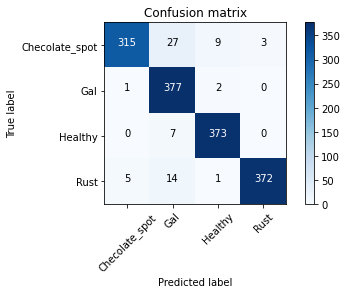

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Get the predicted classes
predictions = alexnet_model.predict(test_set,  1604 // 32 + 1)
predicted_classes = np.argmax(predictions, axis = 1) 

# Get ground-truth classes and class-labels
true_classes = test_set.classes

target_name = ['Checolate_spot', 'Gal', 'Healthy', 'Rust']

confusion_mtx = confusion_matrix(true_classes, predicted_classes)

plot_confusion_matrix(confusion_mtx, classes = target_name) 

Text(0, 0.5, 'Fraction classified incorrectly')

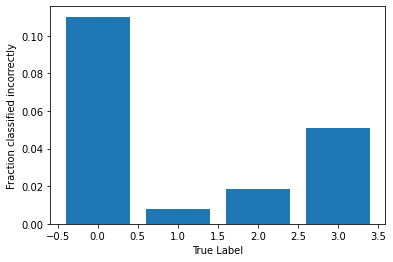

In [8]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(4),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [9]:
print('\nClassification Report\n')
class_labels = ['Checolate_spot', 'gal', 'healthy', 'rust']
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


Classification Report

                precision    recall  f1-score   support

Checolate_spot       0.98      0.89      0.93       354
           gal       0.89      0.99      0.94       380
       healthy       0.97      0.98      0.98       380
          rust       0.99      0.95      0.97       392

      accuracy                           0.95      1506
     macro avg       0.96      0.95      0.95      1506
  weighted avg       0.96      0.95      0.95      1506

